In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Dlnpyutils
# from dlnpyutils.utils import bspline, mad
from dlnpyutils import utils as dln

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

# tqdm
from tqdm.notebook import tqdm

In [2]:
import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757])

def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['logAge'])]
massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']

# APOGEE

In [4]:
dr17 = Table.read('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')

good, = np.where((dr17['SNR']>50) & (dr17['TELESCOPE']!='apo1m') & np.isfinite(dr17['TEFF']) &
                 np.isfinite(dr17['LOGG']) & ((dr17['STARFLAG'] & 2**9)<=0) &
                 ((dr17['ASPCAPFLAG'] & 2**24)<=0))
# STARFLAG    9, persist_high
# ASPCAPFLAG 24, chi2_bad
calib = dr17[good]
for c in calib.colnames: calib[c].name = c.lower()

In [5]:
# Remove columns we don't need
keepcols = ['apogee_id','telescope','location_id','field','ra','dec','j','j_err','h','h_err','k','k_err','ak_targ','ak_wise','sfd_ebv',
           'nvisits','snr','gaiaedr3_source_id','gaiaedr3_source_id','gaiaedr3_pmra','gaiaedr3_pmdec','gaiaedr3_parallax',
           'gaiaedr3_phot_g_mean_mag','gaiaedr3_phot_bp_mean_mag','gaiaedr3_phot_rp_mean_mag',
           'starflag','starflags','aspcapflag','aspcapflags','aspcap_chi2',
           'fparam','teff','teff_err','teff_spec','logg','logg_err','logg_spec','m_h','m_h_err','fe_h','fe_h_err','alpha_m','alpha_m_err']
remcols = []
for c in calib.colnames:
    if c not in keepcols:
        remcols.append(c)
calib.remove_columns(remcols)

In [6]:
# Find duplicate APOGEE_IDs
index = dln.create_index(calib['apogee_id'].data)
bad, = np.where(index['num']>1)
print(len(bad),' duplicates')
torem = []
for i in range(len(bad)):
    ind = index['index'][index['lo'][bad[i]]:index['hi'][bad[i]]+1]
    snr = calib['snr'][ind]
    si = np.flip(np.argsort(snr))
    torem += list(ind[si[1:]])
    #print(index['value'][bad[i]],len(ind))

45476  duplicates


In [7]:
calib.remove_rows(np.array(torem))

In [8]:
index2 = dln.create_index(calib['apogee_id'].data)
bad2, = np.where(index2['num']>1)
print(len(bad2),' duplicates')

0  duplicates


In [9]:
# Save the final catalog
print(len(calib),' final stars')
calib.write('/Users/joshuapovick/Desktop/Research/fits/apogee_library_dr17_rev1.fits',overwrite=True)

537728  final stars


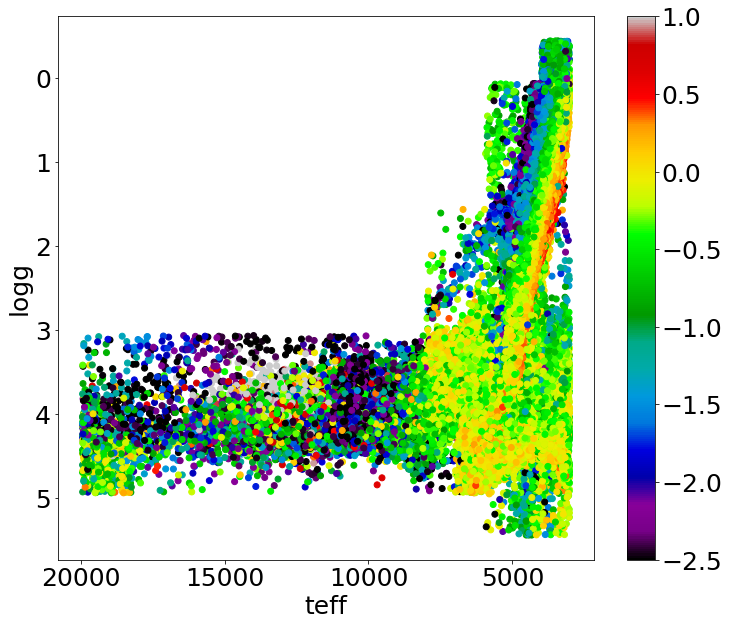

In [10]:
plt.figure(figsize=[12,10])
plt.scatter(calib['fparam'][:,0],calib['fparam'][:,1],c=calib['fparam'][:,3],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'teff')
plt.ylabel(r'logg')
plt.show()

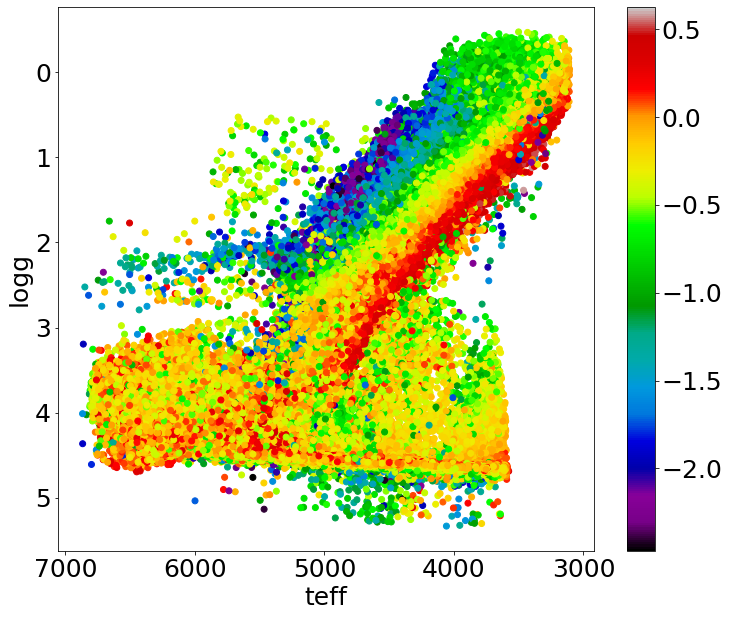

In [11]:
plt.figure(figsize=[12,10])
plt.scatter(calib['teff'],calib['logg'],c=calib['fe_h'],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'teff')
plt.ylabel(r'logg')
plt.show()

In [12]:
# J\"{o}nsson et al. 2020 (https://iopscience.iop.org/article/10.3847/1538-3881/aba592/pdf)

# modified so that minimum uncalibrated log(g) of RC is 2.0

cn = calib['fparam'][:,4]-calib['fparam'][:,5]
dt = calib['teff_spec'] - (4400.+552.6*(calib['logg_spec']-2.5)-324.6*calib['fparam'][:,3])

rc = calib[np.where((calib['fparam'][:,1]>1.5)&(calib['fparam'][:,1]<3.5)&
                   (cn>0.04-0.46*calib['fparam'][:,3]-0.0028*dt))]

rgb = calib[np.where((calib['fparam'][:,1]<3.5)&(calib['fparam'][:,0]<6000.)&
                    (np.isin(calib['apogee_id'],rc['apogee_id'])==False))]

# Get rid of high extinction stars
rgb = rgb[np.where((rgb['sfd_ebv']<0.03))]

In [13]:
### Salaris Correction
afe = rgb['alpha_m']+rgb['m_h']-rgb['fe_h'] # [alpha/Fe]
afe_err = np.sqrt(rgb['alpha_m']**2+rgb['m_h']**2-rgb['fe_h']**2) # [alpha/Fe] err

# 0.659, 0.341 from Asplund et al 2021.
salfeh = rgb['fe_h']+np.log10(0.659*(10**(afe))+0.341)
salfeh_err = np.sqrt(rgb['fe_h_err']**2+
                             ((1-0.341/(0.659*(10**(afe))+0.341))*afe_err)**2)

<ipython-input-13-0111ddd10e50>:3: RuntimeWarning: invalid value encountered in sqrt
  afe_err = np.sqrt(rgb['alpha_m']**2+rgb['m_h']**2-rgb['fe_h']**2) # [alpha/Fe] err


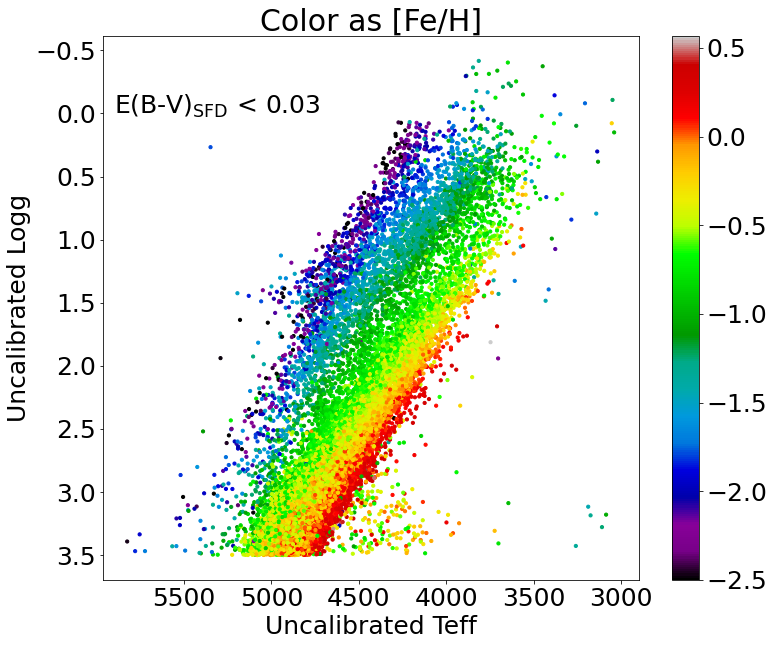

In [14]:
plt.figure(figsize=[12,10])
# plt.scatter(rgb['teff'],rgb['logg'],c=rgb['fe_h'],cmap='nipy_spectral',s=10)
plt.scatter(rgb['fparam'][:,0],rgb['fparam'][:,1],c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.text(5900,0,r'E(B-V)$_{\rm SFD}$ < 0.03')

# high logg cut
# plt.plot([3500,4350],[2.75,2.75],c='tab:purple',lw=3.0)
# plt.plot([4350,4700],[2.75,3.5],c='tab:purple',lw=3.0)
# plt.plot([4700,5600],[3.5,3.5],c='tab:purple',lw=3.0)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'Uncalibrated Logg')
plt.show()

In [15]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

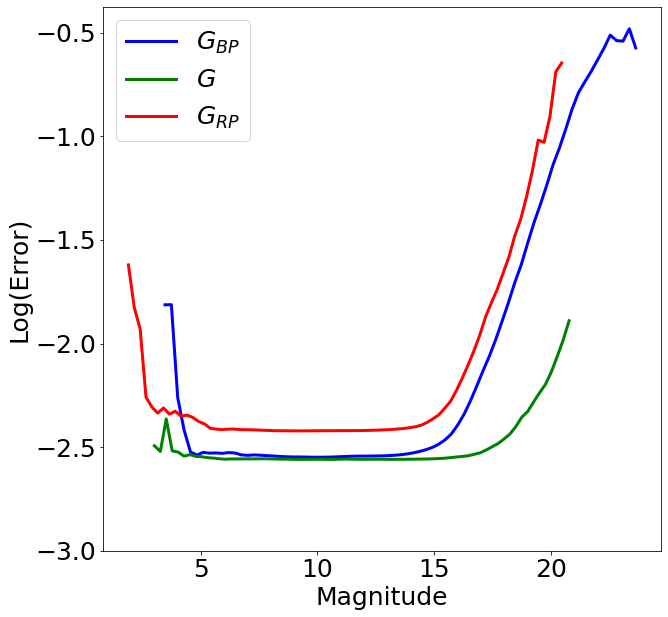

In [16]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = dln.bspline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = dln.bspline(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = dln.bspline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(rgb['gaiaedr3_phot_bp_mean_mag']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(rgb['gaiaedr3_phot_g_mean_mag']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(rgb['gaiaedr3_phot_rp_mean_mag']),nan=0.0037793818)

In [17]:
def color_teff(obsphot,salfeh,isochrones):
    '''
    Calculate the Teff of a star using it's intrinsic color. This assumes either low extinction or dereddened 
    photometry (extinction is ignored).
    
    Inputs:
    ------
        obsphot:    6x2 array
                    array of observed photometry and associated errors
        
        salfeh:     float
                    Salaris corrected [Fe/H]
                    
        isochrones: Table
                    Table of isochrones
    
    Outputs:
    -------
        teff:       float
                    photometric teff value calculated
                    
        teff_err:   float
                    error in the calculated 
    '''
    
    phot = obsphot[:,0]
    phot_err = obsphot[:,1]
    
    color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                             ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
    
    obs_colors = np.delete(phot-phot[1],1)
    obs_colors[1:] = -1*obs_colors[1:]
    obs_colors_err = np.delete(np.sqrt(phot_err**2+phot_err[1]**2),1)
    
    ### Fit color-Teff relation 
    
    # pick out isochrones with same [Fe/H] and cut very young and old ages
    iso = isochrones[np.where(isochrones['MH']==closest(isochrones['MH'],salfeh))]
    iso = iso[np.where((iso['logAge']<np.log10(10**10))&(iso['logAge']>np.log10(0.5*10**9)))]
    
    # calculate the the expect Teff using the five colors
    bspl_vec = 999999.0*np.ones(5)
    bspl_vec_deriv = 999999.0*np.ones(5)
    
    for i in range(5):
        try:
            # Interpolate the color-Teff relation using a b-spline
            color = (iso[color_labels[i,0]]-iso[color_labels[i,1]])
            logTe = iso['logTe']

            bspl = dln.bspline(color,logTe)
            bspl_vec[i] = bspl(obs_colors[i])
            bspl_vec_deriv[i] = bspl.derivative()(obs_colors[i])
        
        except:
            bspl_vec[i] = 999999.0
            bspl_vec_deriv[i] = 999999.0
    
    # Calulate the Teff and associated error
    wgts = np.reciprocal(np.square(np.abs(np.multiply(bspl_vec_deriv,obs_colors_err))))
    wgts_sum = np.sum(wgts)
    
    lgteff = np.sum(np.multiply(wgts,bspl_vec))/wgts_sum
    lgteff_err = np.sqrt(1/wgts_sum)
    
    teff = 10**lgteff
    teff_err = np.abs(teff*np.log(10)*lgteff_err)
    
    return teff,teff_err

# Gonz\'{a}lez-Hern\'{a}ndez & Bonifacio 2009
def ghb_jk_teff(jk_arr,salfeh_arr):
    '''
    Calculate the photometric Teff of a star using Gonz\'{a}lez Hern\'{a}dez & Bonifacio 2009

    Input:
    -----
        jk:   float
              J - K color

    Output:
    ------
        teff: float
              photometric teff
    '''
    
    jk = jk_arr[0]
    jk_err = jk_arr[1]
    salfeh = salfeh_arr[0]
    salfeh_err = salfeh_arr[1]
    
    b = np.array([0.6517,0.6312,0.0168,-0.0381,0.0256,0.0013])

    # Teff Calculation
    theta_eff = b[0]+b[1]*jk+b[2]*(jk**2)+b[3]*(jk*salfeh)+b[4]*salfeh+b[5]*(salfeh**2)
    teff = 5040/theta_eff
    
    
    # Teff Error
    theta_eff_deriv_jk = b[1]+2*b[2]*jk+b[3]*salfeh
    theta_eff_derive_salfeh = b[3]*jk+b[4]+2*b[5]*salfeh
    
    theta_eff_err = np.sqrt(np.abs(theta_eff_deriv_jk*jk_err)**2+np.abs(theta_eff_derive_salfeh*salfeh_err)**2)
    teff_err = np.abs(5040/theta_eff**2)*theta_eff_err
    
    return teff,teff_err

In [18]:
def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

photteffs = 999999.0*np.ones(len(np.squeeze(rgb)))
photteffs_err = 999999.0*np.ones(len(np.squeeze(rgb)))
ghbteffs = 999999.0*np.ones(len(np.squeeze(rgb)))
ghbteffs_err = 999999.0*np.ones(len(np.squeeze(rgb)))

for i in tqdm(range(len(np.squeeze(rgb)))):

    op = np.array([[rgb['gaiaedr3_phot_bp_mean_mag'][i],
                    rgb['gaiaedr3_phot_g_mean_mag'][i],
                    rgb['gaiaedr3_phot_rp_mean_mag'][i],
                    rgb['j'][i],rgb['h'][i],
                    rgb['k'][i]],
                   [bperr[i],gerr[i],rperr[i],
                    rgb['j_err'][i],rgb['h_err'][i],
                    rgb['k_err'][i]]]).T
    
    photteffs[i], photteffs_err[i] = color_teff(op,salfeh[i],massive)
    
    
    jk = np.array([rgb['j'][i]-rgb['k'][i],np.sqrt(rgb['j_err'][i]**2+rgb['k'][i]**2)])
    sfeh = np.array([salfeh[i],salfeh_err[i]])
    
    ghbteffs[i], ghbteffs_err[i] = ghb_jk_teff(jk,sfeh)

  0%|          | 0/20214 [00:00<?, ?it/s]

<ipython-input-18-afedb2a992fa>:43: UserWarning: Warning: converting a masked element to nan.
  sfeh = np.array([salfeh[i],salfeh_err[i]])
<ipython-input-18-afedb2a992fa>:30: UserWarning: Warning: converting a masked element to nan.
  op = np.array([[rgb['gaiaedr3_phot_bp_mean_mag'][i],
<ipython-input-18-afedb2a992fa>:42: UserWarning: Warning: converting a masked element to nan.
  jk = np.array([rgb['j'][i]-rgb['k'][i],np.sqrt(rgb['j_err'][i]**2+rgb['k'][i]**2)])


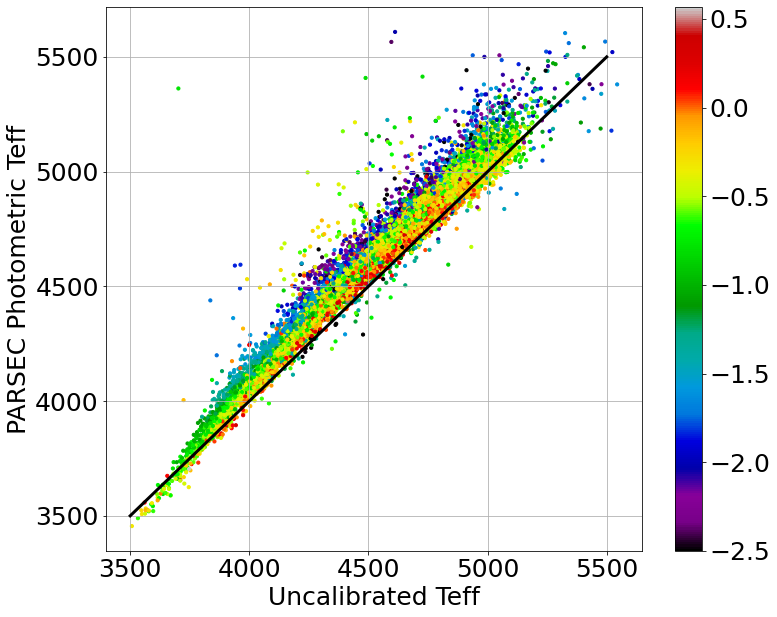

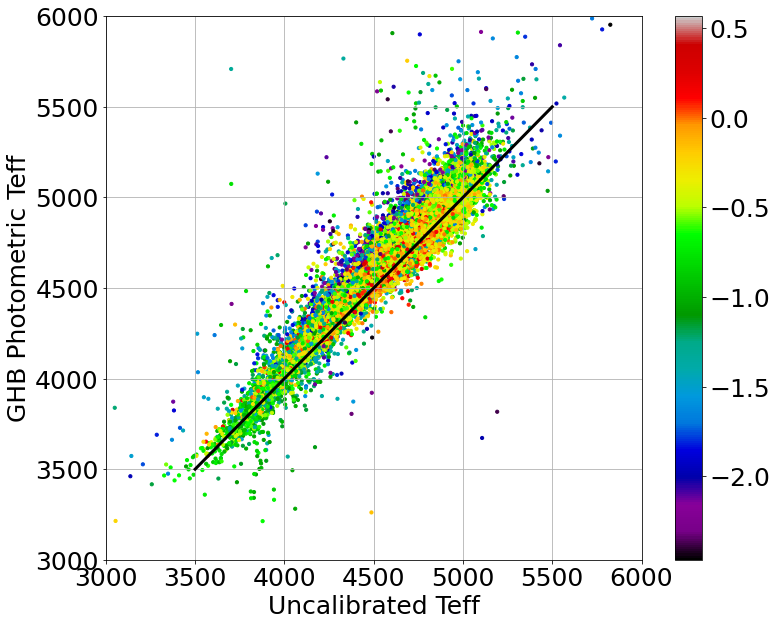

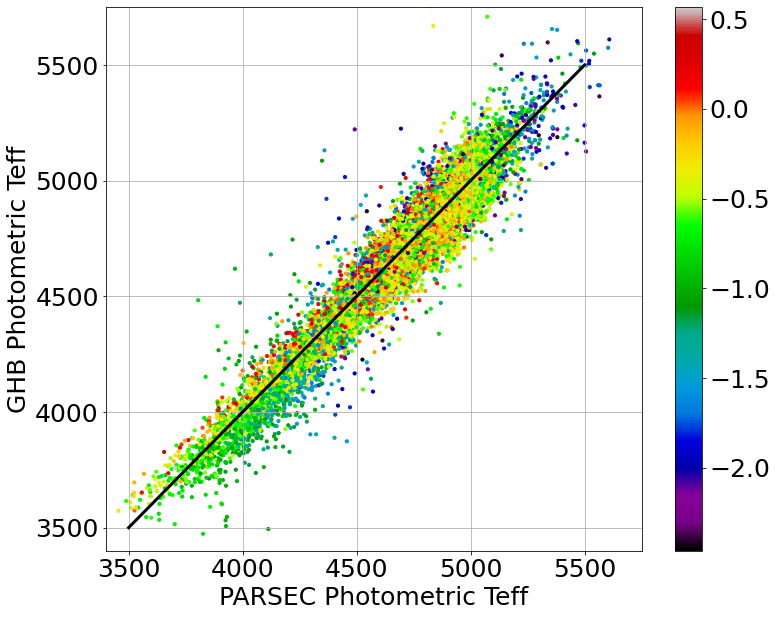

In [19]:
plt.figure(figsize=[12,10])
plt.scatter(rgb['fparam'][:,0],photteffs,c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.plot([3500,5500],[3500,5500],c='k',lw=3.0)
plt.grid()
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'PARSEC Photometric Teff')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(rgb['fparam'][:,0],ghbteffs,c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.plot([3500,5500],[3500,5500],c='k',lw=3.0)
plt.xlim(3000,6000)
plt.ylim(3000,6000)
plt.grid()
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'GHB Photometric Teff')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(photteffs,ghbteffs,c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.plot([3500,5500],[3500,5500],c='k',lw=3.0)
plt.xlim(3400,5750)
plt.ylim(3400,5750)
plt.grid()
plt.xlabel(r'PARSEC Photometric Teff')
plt.ylabel(r'GHB Photometric Teff')
plt.show()

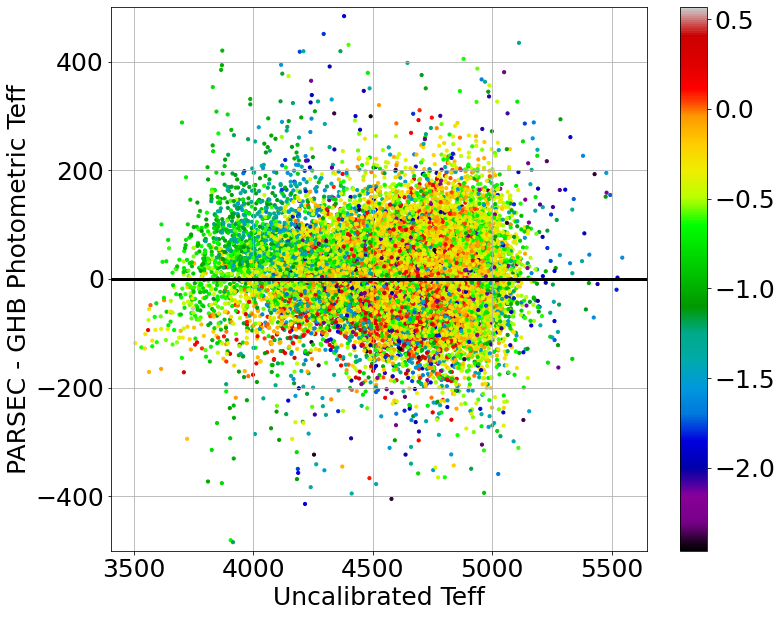

In [20]:
plt.figure(figsize=[12,10])
plt.scatter(rgb['fparam'][:,0],photteffs-ghbteffs,c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.,c='k',lw=3.0)
plt.ylim(-500,500)
plt.grid()
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'PARSEC - GHB Photometric Teff')
plt.show()

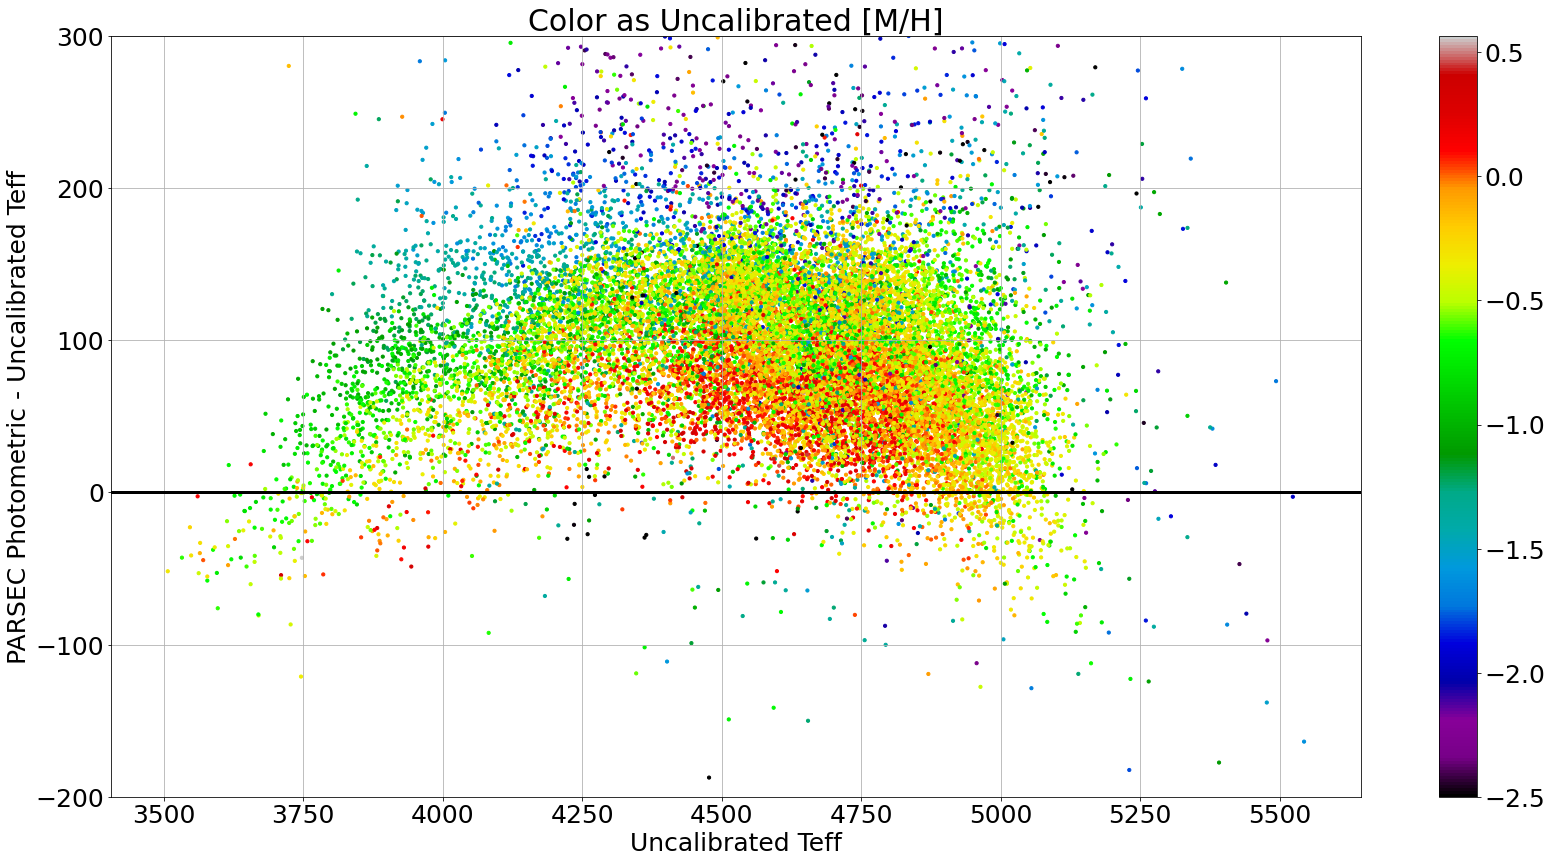

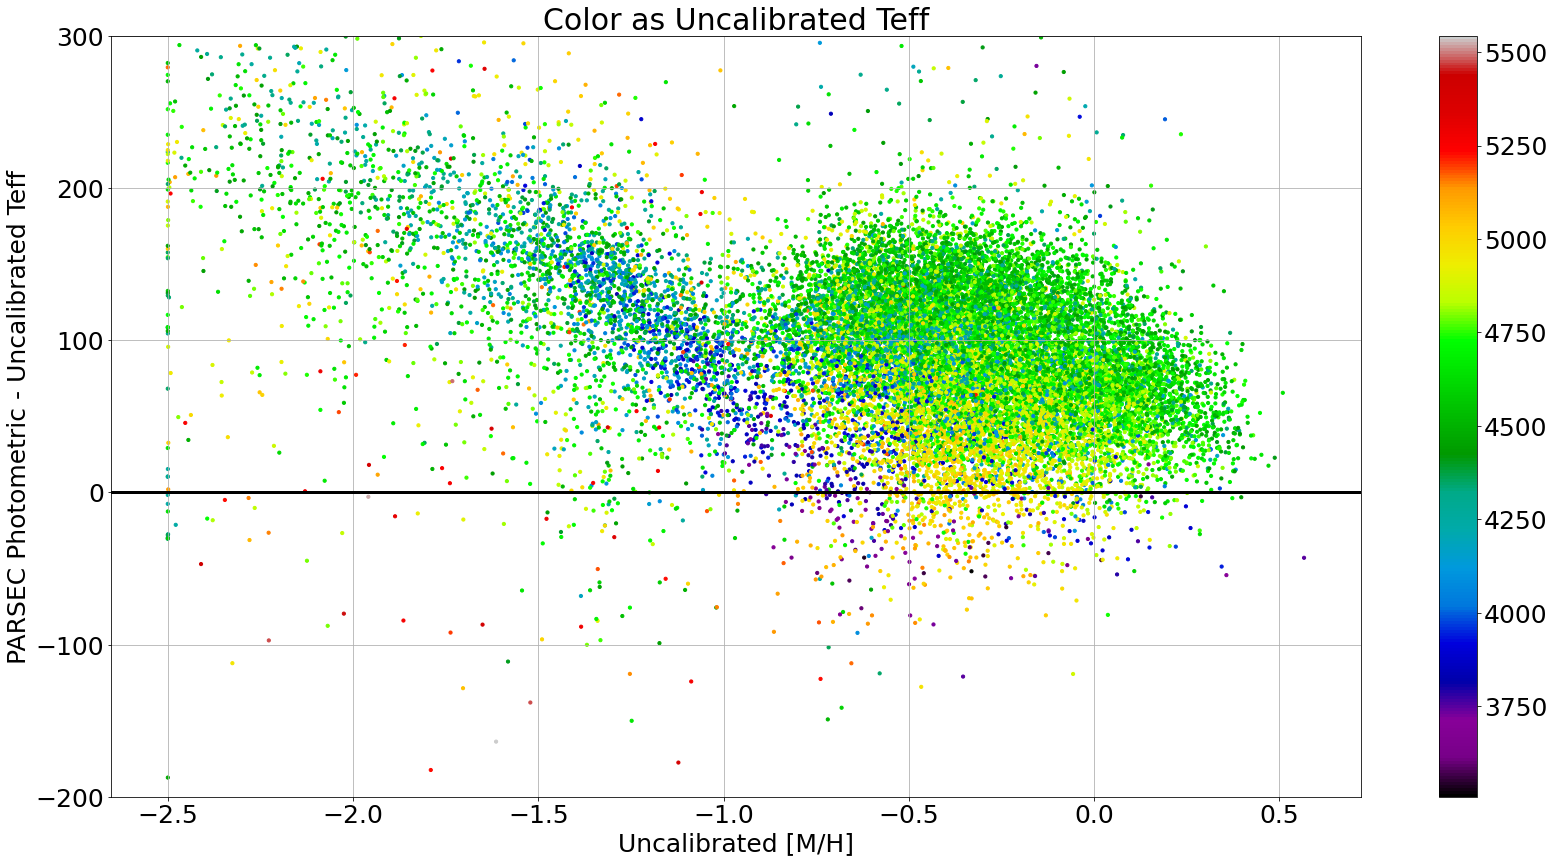

In [21]:
plt.figure(figsize=[28,14])
plt.scatter(rgb['fparam'][:,0],photteffs-rgb['fparam'][:,0],c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
# plt.ylim(-200,350)
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
plt.show()

###
plt.figure(figsize=[28,14])
plt.scatter(rgb['fparam'][:,3],photteffs-rgb['fparam'][:,0],c=rgb['fparam'][:,0],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
# plt.ylim(-200,350)
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Color as Uncalibrated Teff')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
plt.show()

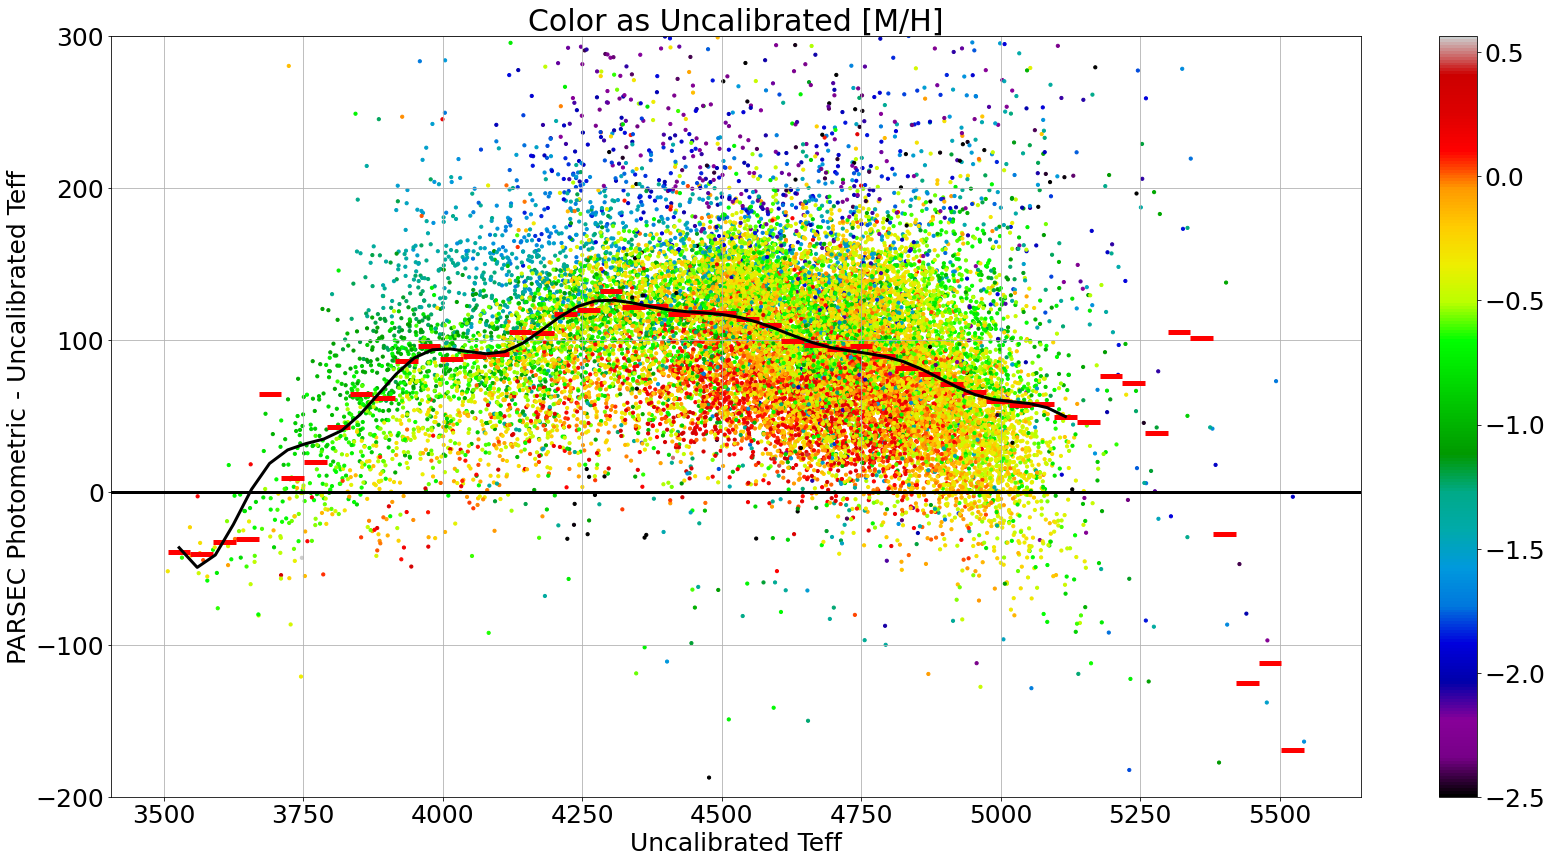

In [22]:
teff_fin = np.where((np.isfinite(rgb['fparam'][:,0])==True)&(np.isfinite(photteffs)==True))

teffmeds,teffedgs,_ = binned_statistic(rgb['fparam'][:,0][teff_fin],(photteffs-rgb['fparam'][:,0])[teff_fin],bins=50)
teffcens = teffedgs[:-1]+np.nanmedian(np.diff(teffedgs))/2.

teff_spl = dln.bspline(teffcens[:-10],teffmeds[:-10],extrapolate=True)
teff_xs = np.linspace(min(teffcens[:-10]),max(teffcens[:-10]))

plt.figure(figsize=[28,14])
plt.scatter(rgb['fparam'][:,0],photteffs-rgb['fparam'][:,0],c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.hlines(teffmeds,teffedgs[:-1],teffedgs[1:], colors='r', lw=5.)
plt.plot(teff_xs,teff_spl(teff_xs),c='k',lw=3.0)
plt.axhline(0.0,c='k',lw=3.0)
# plt.ylim(-200,350)
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
plt.show()

In [55]:
np.median(rgb['fparam'][:,3])

-0.4103949964046478

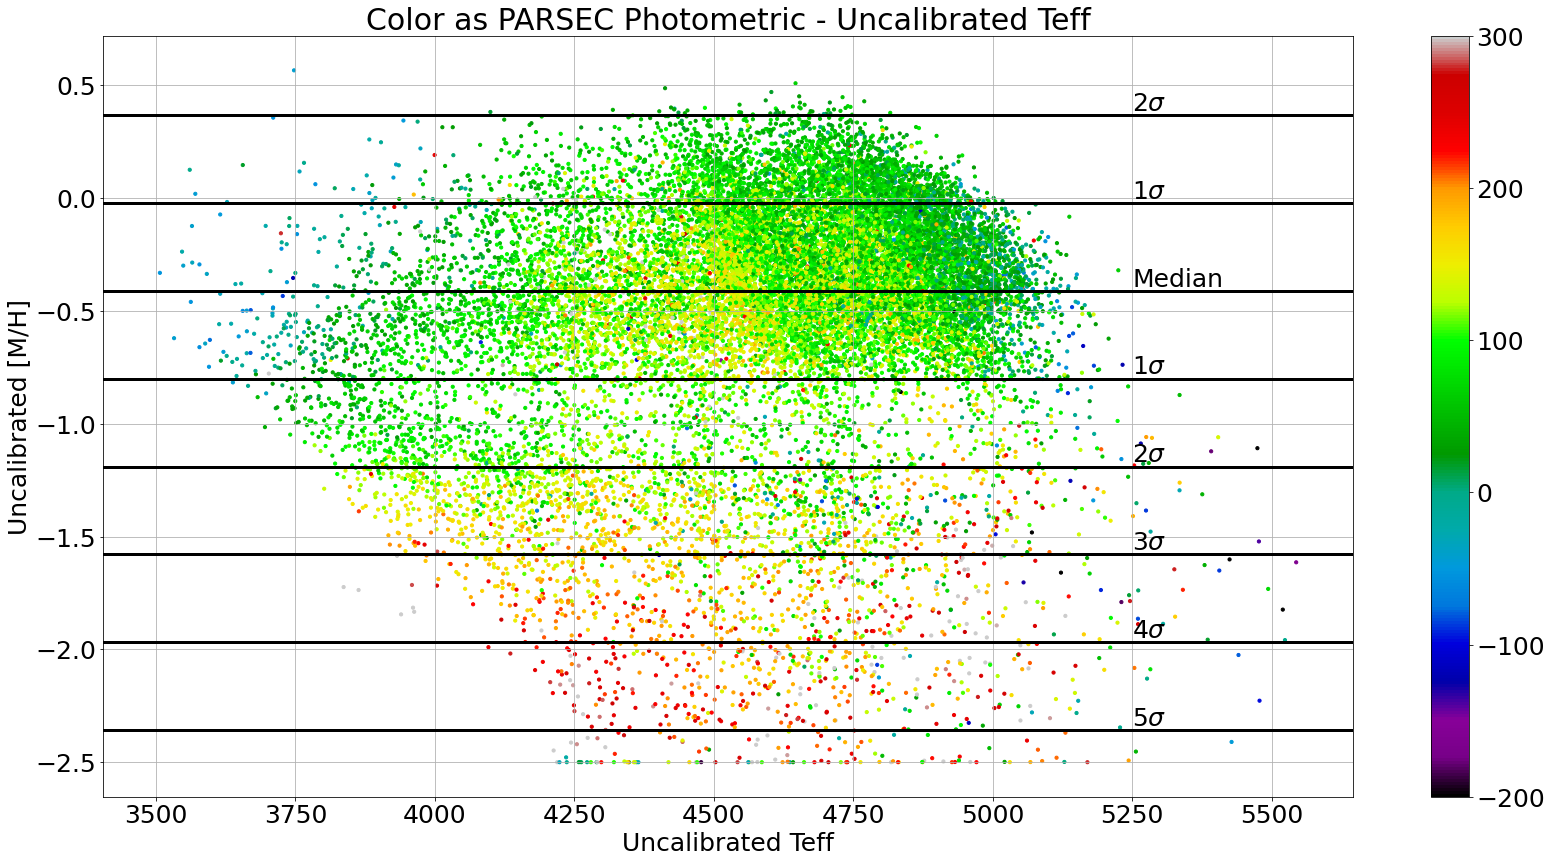

In [66]:
plt.figure(figsize=[28,14])
plt.scatter(rgb['fparam'][:,0],rgb['fparam'][:,3],c=photteffs-rgb['fparam'][:,0],
            cmap='nipy_spectral',s=10,vmin=-200,vmax=300)


plt.axhline(np.median(rgb['fparam'][:,3]),c='k',lw=3.0)
plt.text(5250,-0.39,'Median')

for i in np.delete(range(6),0):
    if i > 2:
        plt.axhline(np.median(rgb['fparam'][:,3])-i*dln.mad(rgb['fparam'][:,3]),c='k',lw=3.0)
        plt.text(5250,-0.39-i*dln.mad(rgb['fparam'][:,3]),r'{}$\sigma$'.format(i))
    
    else:
        plt.axhline(np.median(rgb['fparam'][:,3])-i*dln.mad(rgb['fparam'][:,3]),c='k',lw=3.0)
        plt.text(5250,-0.39-i*dln.mad(rgb['fparam'][:,3]),r'{}$\sigma$'.format(i))
        
        plt.axhline(np.median(rgb['fparam'][:,3])+i*dln.mad(rgb['fparam'][:,3]),c='k',lw=3.0)
        plt.text(5250,-0.39+i*dln.mad(rgb['fparam'][:,3]),r'{}$\sigma$'.format(i))

plt.colorbar()
plt.grid()
plt.ylabel(r'Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.title(r'Color as PARSEC Photometric - Uncalibrated Teff')
plt.show()

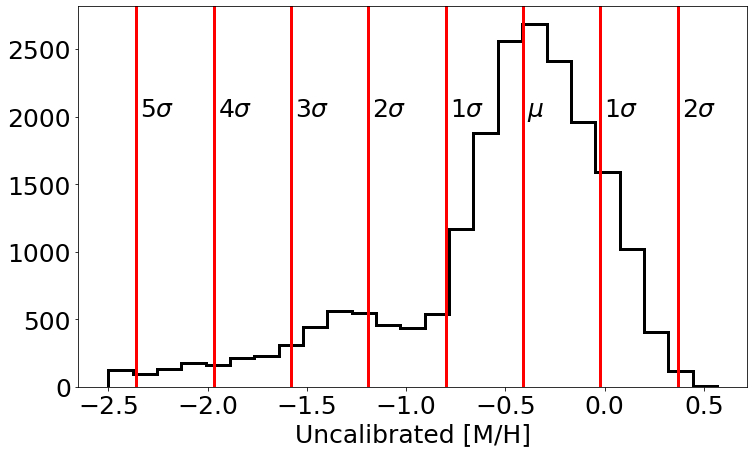

In [75]:
plt.figure(figsize=[12,7])
plt.hist(rgb['fparam'][:,3],color='k',lw=3.0,histtype='step',bins=25)

plt.axvline(np.median(rgb['fparam'][:,3]),c='r',lw=3.0)
plt.text(-0.39,2000,r'$\mu$')

for i in np.delete(range(6),0):
    if i > 2:
        plt.axvline(np.median(rgb['fparam'][:,3])-i*dln.mad(rgb['fparam'][:,3]),c='r',lw=3.0)
        plt.text(-0.39-i*dln.mad(rgb['fparam'][:,3]),2000,r'{}$\sigma$'.format(i))
    
    else:
        plt.axvline(np.median(rgb['fparam'][:,3])-i*dln.mad(rgb['fparam'][:,3]),c='r',lw=3.0)
        plt.text(-0.39-i*dln.mad(rgb['fparam'][:,3]),2000,r'{}$\sigma$'.format(i))
        
        plt.axvline(np.median(rgb['fparam'][:,3])+i*dln.mad(rgb['fparam'][:,3]),c='r',lw=3.0)
        plt.text(-0.39+i*dln.mad(rgb['fparam'][:,3]),2000,r'{}$\sigma$'.format(i))
        
plt.xlabel(r'Uncalibrated [M/H]')
plt.show()

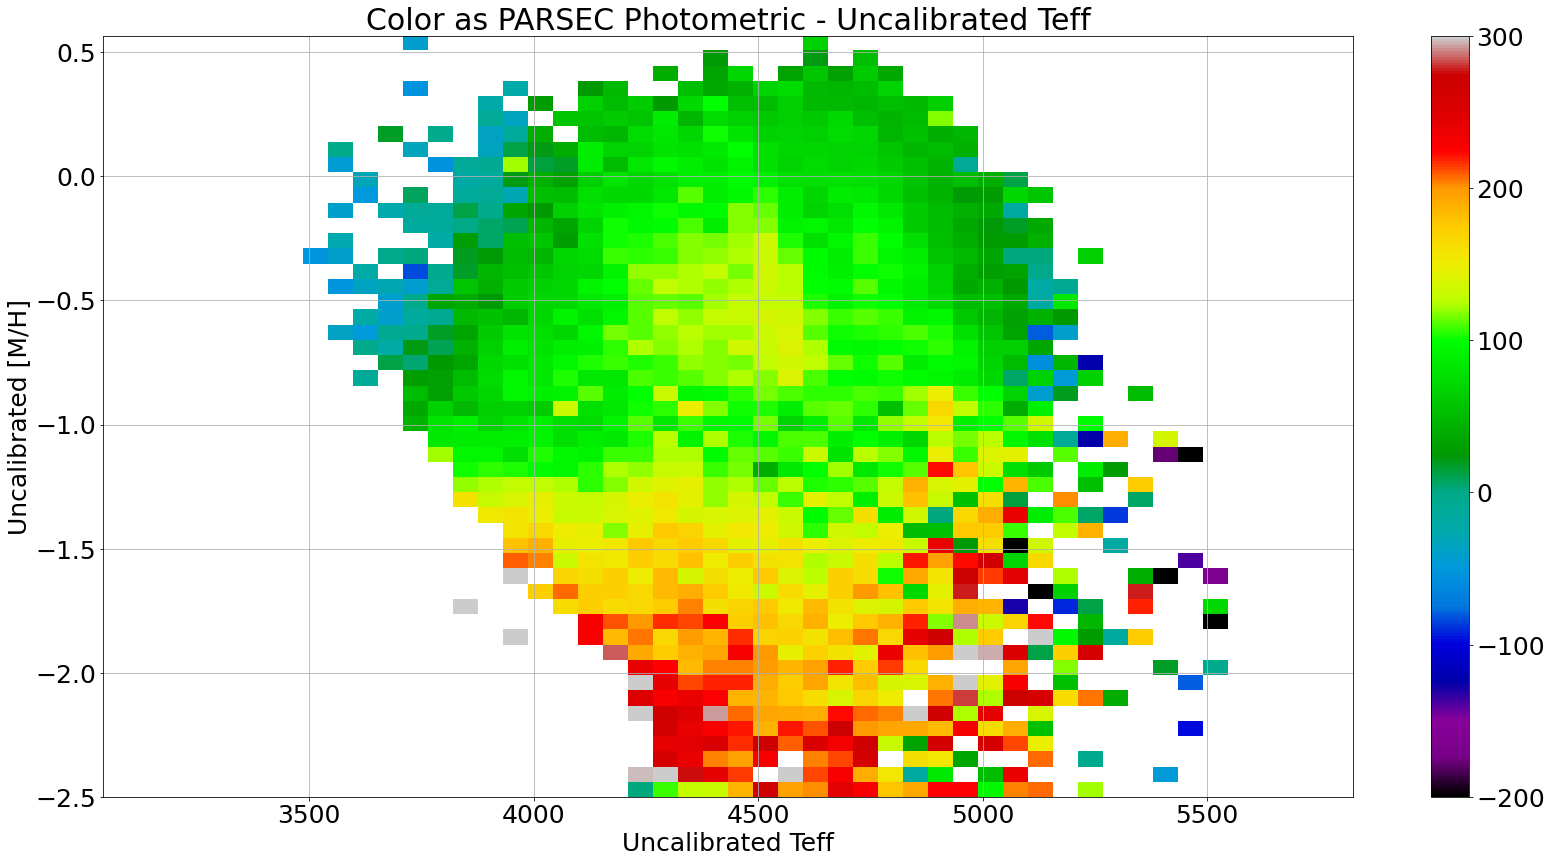

In [76]:
plt.figure(figsize=[28,14])

teff_ret = binned_statistic_2d(rgb['fparam'][:,0],rgb['fparam'][:,3],photteffs-rgb['fparam'][:,0],'median',
                                  bins=50)

teff_ret.statistic[teff_ret.statistic == 0.0] = np.nan

im = plt.imshow(teff_ret.statistic.T, origin='lower',
                extent=[teff_ret.x_edge[0],teff_ret.x_edge[-1],
                        teff_ret.y_edge[0],teff_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=-200,vmax=300)

plt.colorbar()
plt.grid()
plt.ylabel(r'Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.title(r'Color as PARSEC Photometric - Uncalibrated Teff')
plt.savefig('uncal_feh_teff_dteff.png',bbox_inches='tight')
plt.show()

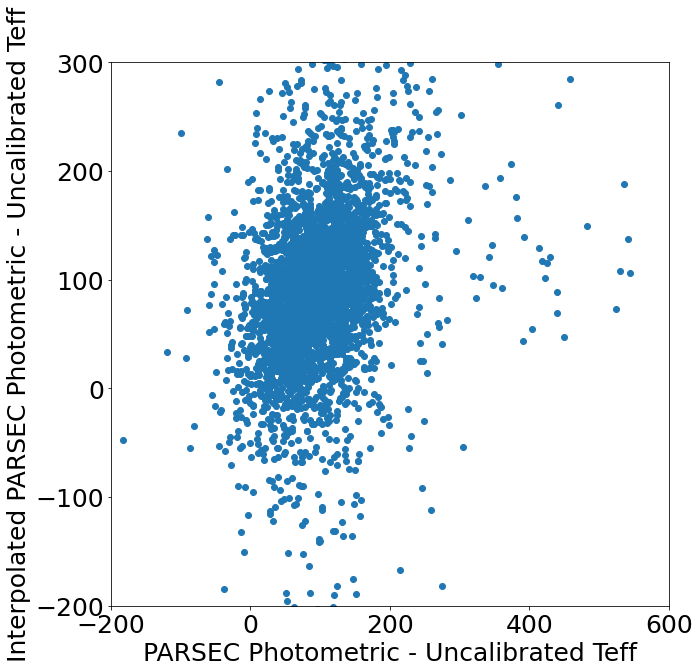

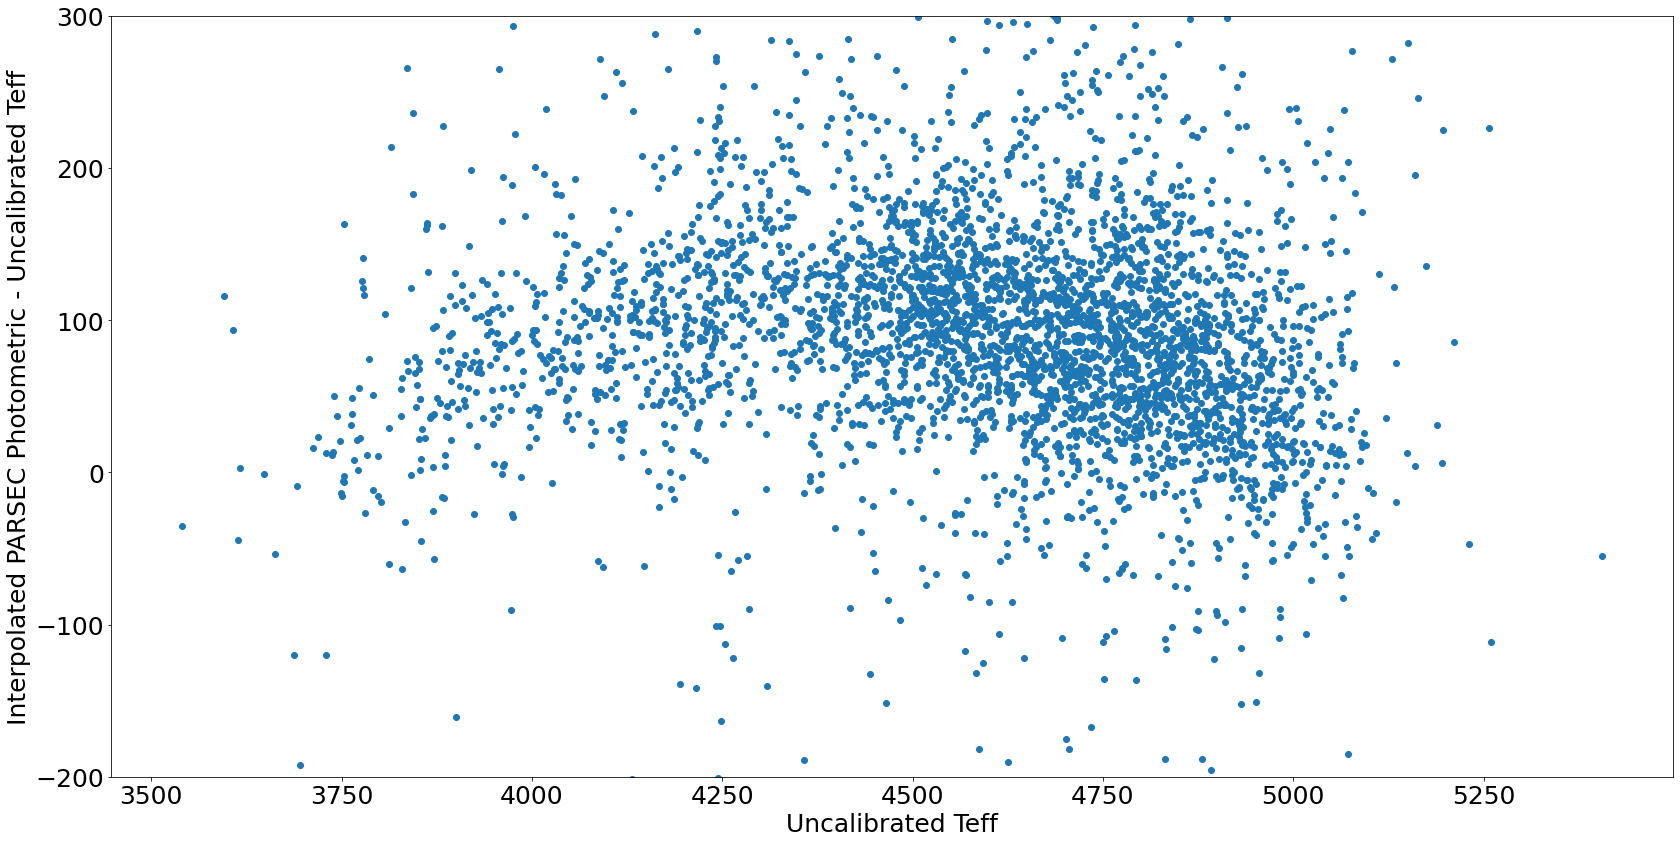

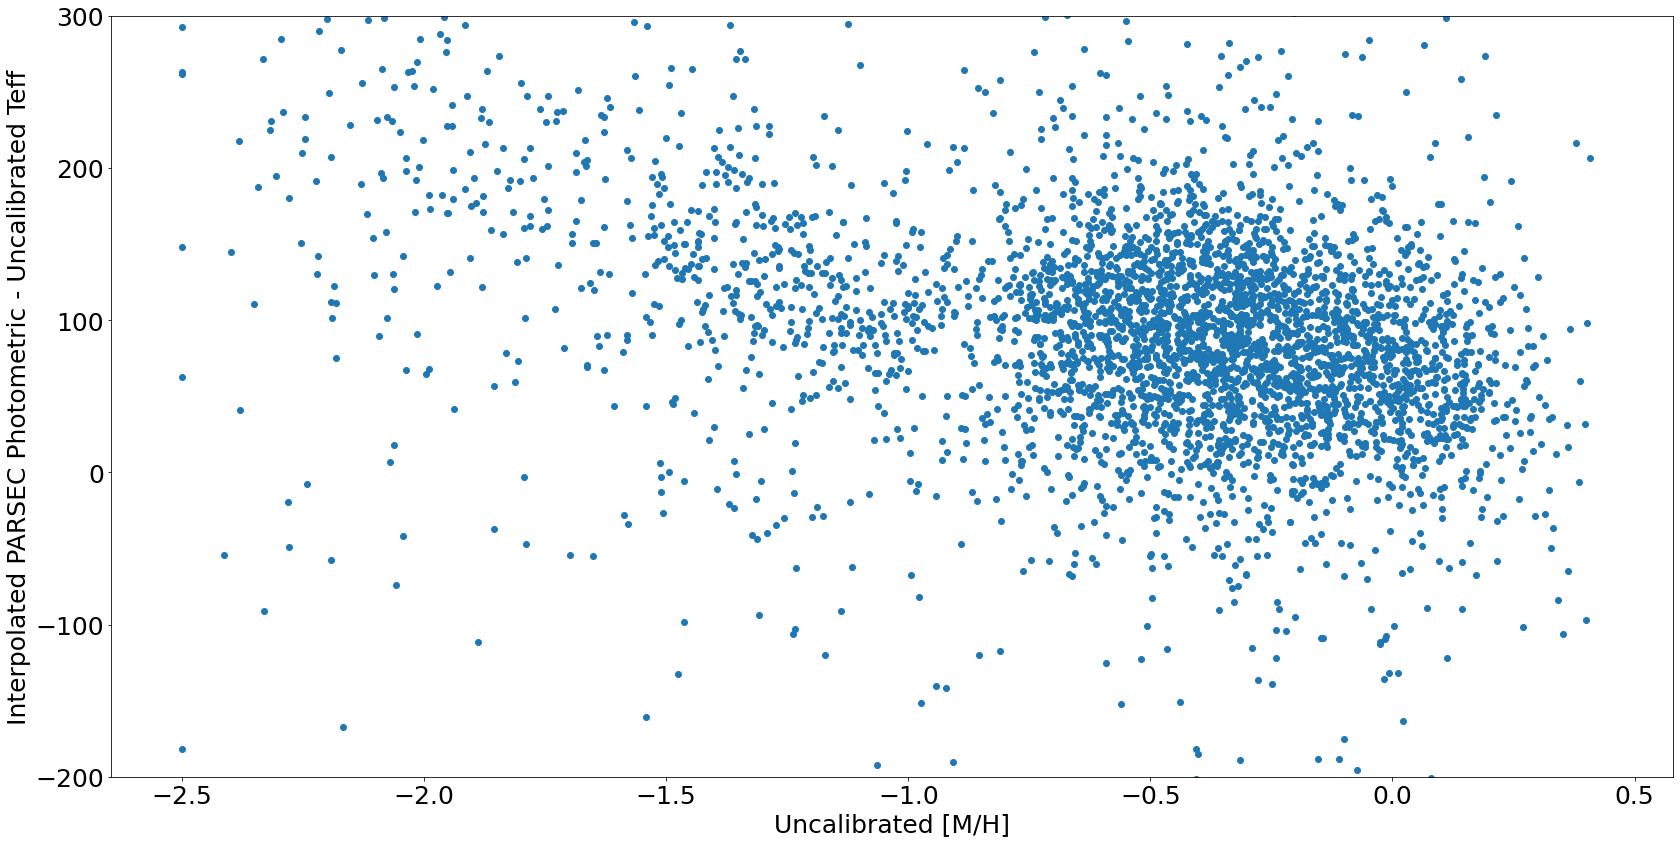

Median Residual 1.829 +/ 63.681


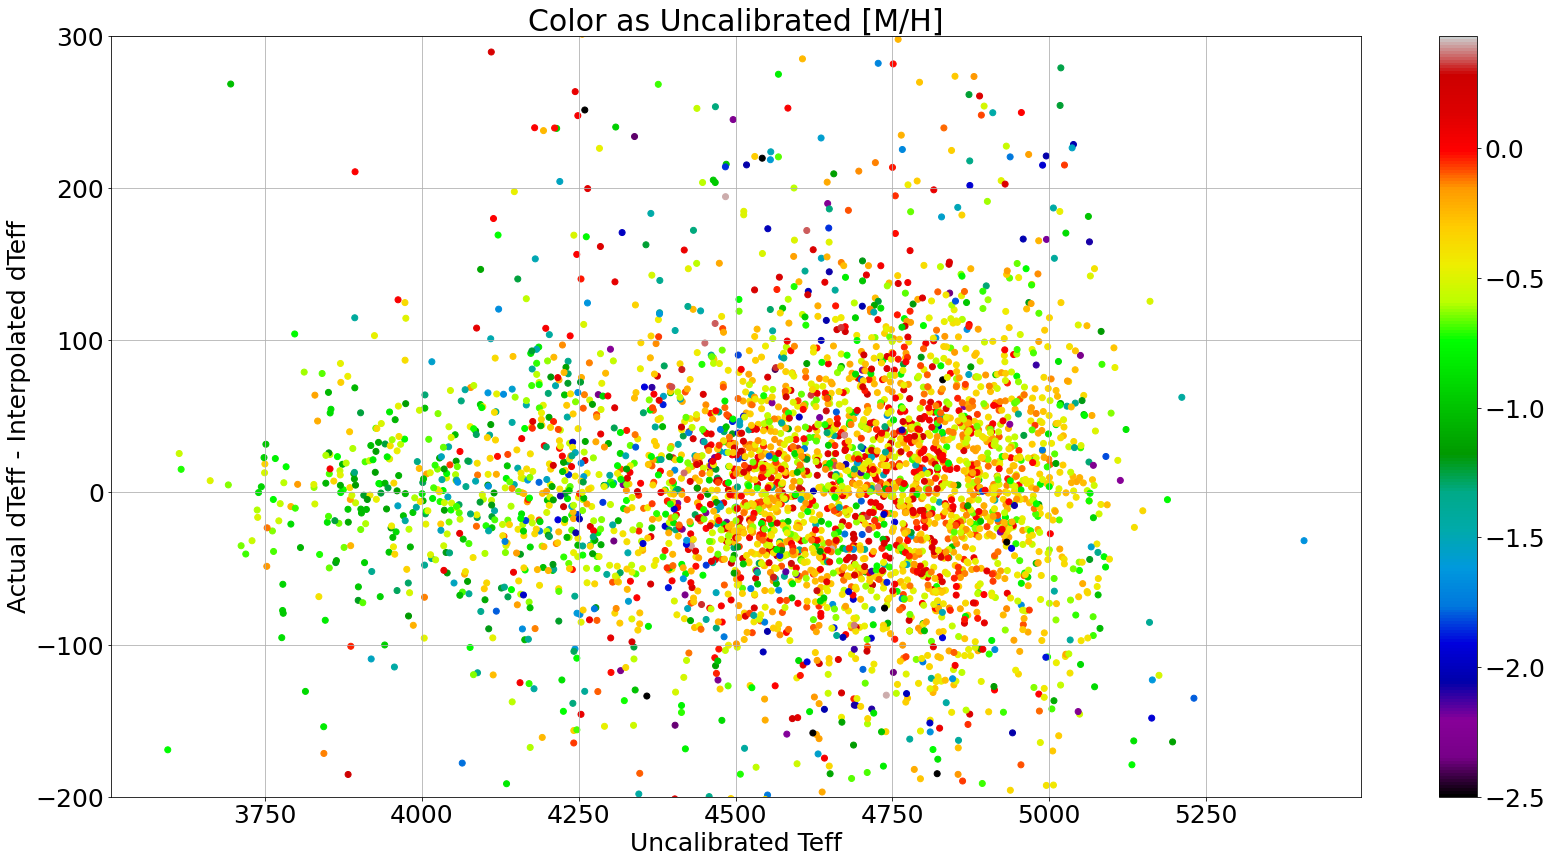

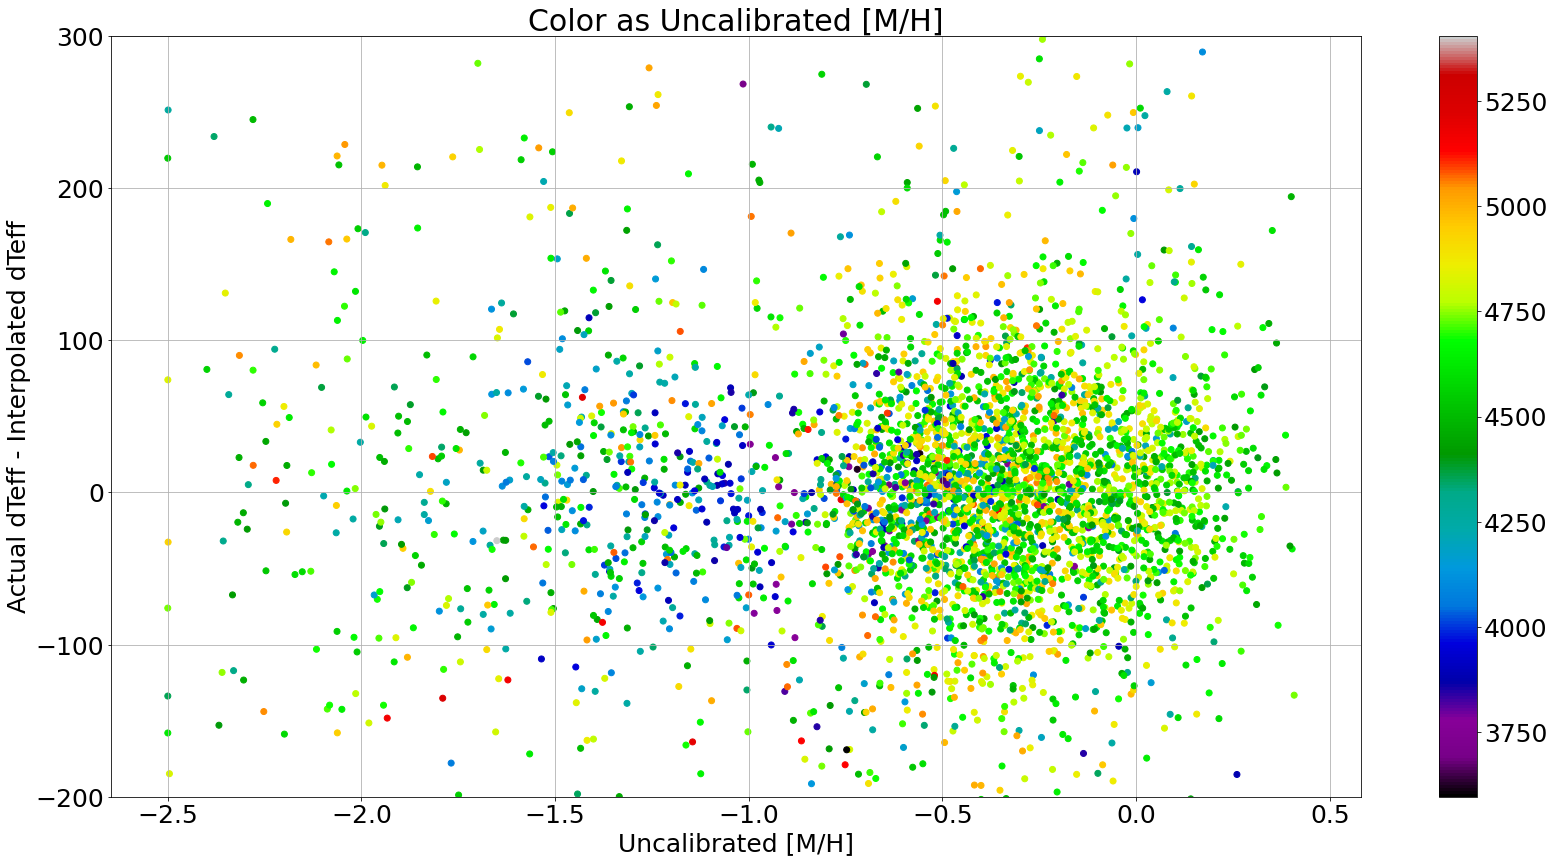

In [77]:
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata

teff_feh = np.array([rgb['fparam'][:,0],rgb['fparam'][:,3]]).T
dteff = photteffs - rgb['fparam'][:,0]

teff_feh_train, teff_feh_test, dteff_train, dteff_test = train_test_split(
teff_feh, dteff, test_size=0.20)


### Fit Bicubic Spline with train data

fincut_train = np.where((np.isfinite(teff_feh_train[:,0])==True)&(np.isfinite(teff_feh_train[:,1])==True)&
                        (np.isfinite(dteff_train)==True))

interp_dteff = griddata(teff_feh_train[fincut_train],dteff_train[fincut_train],
                        (teff_feh_test[:,0],teff_feh_test[:,1]),method='cubic')

plt.figure(figsize=[10,10])
plt.scatter(dteff_test,interp_dteff)
plt.xlim(-200,600)
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.xlabel(r'PARSEC Photometric - Uncalibrated Teff')
plt.ylabel(r'Interpolated PARSEC Photometric - Uncalibrated Teff')
plt.show()

plt.figure(figsize=[28,14])
plt.scatter(teff_feh_test[:,0],interp_dteff)
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'Interpolated PARSEC Photometric - Uncalibrated Teff')
plt.show()

plt.figure(figsize=[28,14])
plt.scatter(teff_feh_test[:,1],interp_dteff)
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'Interpolated PARSEC Photometric - Uncalibrated Teff')
plt.show()

###############################

print(r'Median Residual {:.3f} +/ {:.3f}'.format(np.nanmedian(dteff_test - interp_dteff),dln.mad(dteff_test - interp_dteff)))

plt.figure(figsize=[28,14])
plt.scatter(teff_feh_test[:,0], dteff_test - interp_dteff, c = teff_feh_test[:,1], cmap='nipy_spectral')
plt.colorbar()
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'Actual dTeff - Interpolated dTeff')
plt.grid()
plt.show()

plt.figure(figsize=[28,14])
plt.scatter(teff_feh_test[:,1],dteff_test - interp_dteff, c = teff_feh_test[:,0], cmap='nipy_spectral')
plt.colorbar()
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'Actual dTeff - Interpolated dTeff')
plt.grid()
plt.show()

In [26]:
# plt.figure(figsize=[28,14])
# plt.scatter(rgb['fparam'][:,0],photteffs-new_teff,c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
# plt.colorbar()
# plt.axhline(0.0,c='k',lw=3.0)
# # plt.ylim(-200,350)
# # plt.ylim(-600,600)
# # plt.ylim(-200,300)
# plt.grid()
# plt.title(r'Color as Uncalibrated [M/H]')
# plt.xlabel(r'Uncalibrated Teff')
# plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
# plt.show()

# ###
# plt.figure(figsize=[28,14])
# plt.scatter(rgb['fparam'][:,3],photteffs-new_teff,c=rgb['fparam'][:,0],cmap='nipy_spectral',s=10)
# plt.colorbar()
# plt.axhline(0.0,c='k',lw=3.0)
# # plt.ylim(-200,350)
# # plt.ylim(-600,600)
# # plt.ylim(-200,300)
# plt.grid()
# plt.title(r'Color as Uncalibrated Teff')
# plt.xlabel(r'Uncalibrated [M/H]')
# plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
# plt.show()

In [27]:
# import numpy as np
# from scipy.interpolate import interp2d
# import matplotlib.pyplot as plt

# x = rgb['fparam'][:,0]
# y = rgb['fparam'][:,3]
# X, Y = np.meshgrid(x, y)
# Z = photteffs-rgb['fparam'][:,0] #np.sin(np.pi*X/2) * np.exp(Y/2)

# x2 = np.linspace(3500, 5500, 100)
# y2 = np.linspace(-2.5, 0.6, 100)
# f = interp2d(x, y, Z, kind='cubic')
# Z2 = f(x2, y2)

# fig, ax = plt.subplots(nrows=1, ncols=2)
# ax[0].pcolormesh(X, Y, Z, cmap='nipy_spectral')

# X2, Y2 = np.meshgrid(x2, y2)
# ax[1].pcolormesh(X2, Y2, Z2, cmap='nipy_spectral')

# plt.show()


In [28]:
# np.sin(np.pi*X/2) * np.exp(Y/2)

In [29]:
# from scipy.interpolate import interp2d

# fincut = np.where((np.isfinite(rgb['fparam'][:,0])==True)&(np.isfinite(rgb['fparam'][:,3])==True)&
#                   (np.isfinite(photteffs)==True))

# xx, yy = np.meshgrid(rgb['fparam'][:,0][fincut],rgb['fparam'][:,3][fincut])
# # f = interp2d(xx,yy,(photteffs-rgb['fparam'][:,0])[fincut],kind='cubic')

In [30]:
# def func(x, y):
#     return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

# grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

# rng = np.random.default_rng()
# points = rng.random((1000, 2))
# values = func(points[:,0], points[:,1])

In [31]:
# fincut = np.where((np.isfinite(rgb['fparam'][:,0])==True)&(np.isfinite(rgb['fparam'][:,0])==True)&
#                   (np.isfinite(photteffs)==True))

# teff_feh = np.array([rgb['fparam'][:,0][fincut],rgb['fparam'][:,3][fincut]]).T

# grid_teff = np.linspace(np.nanmin(rgb['fparam'][:,0]),np.nanmax(rgb['fparam'][:,0]),1000)
# grid_feh = np.linspace(np.nanmin(rgb['fparam'][:,3]),np.nanmax(rgb['fparam'][:,3]),1000)



# grid_dteff = griddata(teff_feh, (photteffs-rgb['fparam'][:,0])[fincut], (grid_teff,grid_feh), method='cubic')

In [32]:
# grid_dteff

In [33]:
# import numpy as np
# from scipy.interpolate import griddata
# import matplotlib.pyplot as plt


# N = 100
# M = 10

# lat   = ((np.random.rand(M,N))*2)+0.2
# lon   = ((np.random.rand(M,N))*3)+0.2
# theta = ((np.random.rand(M,N))*180)
# lat_min = np.min(lat)
# lat_max = np.max(lat)
# lon_min = np.min(lon)
# lon_max = np.max(lon)

# dlat = 0.1            # regular step for the lat[rad]
# dlon = 0.1           # regular step for the lon[rad]

# # Grid dimensions
# Nlat = int(np.abs(lat_max-lat_min)/dlat)+1
# Nlon = int(np.abs(lon_max-lon_min)/dlon)+1

# # Lat-Lon vector
# reg_lat = np.linspace(lat_min, lat_max, Nlat)  # regularly spaced latitude vector
# reg_lon = np.linspace(lon_min, lon_max, Nlon)  # regularly spaced longitude vector
# # Lat-Lon regular Grid
# reg_lon_mesh, reg_lat_mesh = np.meshgrid(reg_lon, reg_lat)

# theta2 = griddata((lon.ravel(), lat.ravel()), theta.ravel(),(reg_lon_mesh, reg_lat_mesh), method='cubic')

# plt.imshow(theta2.T, extent=(0,1,0,1), origin='lower')

In [34]:
# import numpy as np
# from scipy.interpolate import griddata
# import matplotlib.pyplot as plt


# N = 100
# M = 10

# lat   = ((np.random.rand(M,N))*2)+0.2
# lon   = ((np.random.rand(M,N))*3)+0.2
# theta = ((np.random.rand(M,N))*180)
# lat_min = np.min(lat)
# lat_max = np.max(lat)
# lon_min = np.min(lon)
# lon_max = np.max(lon)

# dlat = 0.1            # regular step for the lat[rad]
# dlon = 0.1           # regular step for the lon[rad]

# # Grid dimensions
# Nlat = int(np.abs(lat_max-lat_min)/dlat)+1
# Nlon = int(np.abs(lon_max-lon_min)/dlon)+1

# # Lat-Lon vector
# reg_lat = np.linspace(lat_min, lat_max, Nlat)  # regularly spaced latitude vector
# reg_lon = np.linspace(lon_min, lon_max, Nlon)  # regularly spaced longitude vector
# # Lat-Lon regular Grid
# reg_lon_mesh, reg_lat_mesh = np.meshgrid(reg_lon, reg_lat)

# theta2 = griddata((lon.ravel(), lat.ravel()), theta.ravel(),(reg_lon_mesh, reg_lat_mesh), method='cubic')

# plt.imshow(theta2.T, extent=(0,1,0,1), origin='lower')

In [35]:
from scipy.interpolate import griddata
# grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
# grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
# grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

# # import matplotlib.pyplot as plt
# plt.subplot(221)
# plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
# plt.plot(points[:,0], points[:,1], 'k.', ms=1)
# plt.title('Original')
# plt.subplot(222)
# plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
# plt.title('Nearest')
# plt.subplot(223)
# plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
# plt.title('Linear')
# plt.subplot(224)
# plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
# plt.title('Cubic')
# plt.gcf().set_size_inches(10, 10)
# plt.show()

In [36]:
# np.shape(grid_z2)

In [37]:
# np.shape(grid_dteff)

In [38]:
# grid_dteff.T

In [39]:
# plt.figure(figsize=[28,14])


# im = plt.pcolormesh(grid_dteff.T,extent=(0,1,0,1), origin='lower')

# plt.colorbar()
# plt.show()

In [40]:
# grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [41]:
# plt.figure(figsize=[28,14])
# plt.scatter(rgb['fparam'][:,0],photteffs-(rgb['fparam'][:,0]+f(rgb['fparam'][:,0],rgb['fparam'][:,3])),
#             c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
# plt.colorbar()
# plt.hlines(teffmeds,teffedgs[:-1],teffedgs[1:], colors='r', lw=5.)
# plt.plot(teff_xs,teff_spl(teff_xs),c='k',lw=3.0)
# plt.axhline(0.0,c='k',lw=3.0)
# # plt.ylim(-200,350)
# # plt.ylim(-600,600)
# plt.ylim(-200,300)
# plt.grid()
# plt.title(r'Color as Uncalibrated [M/H]')
# plt.xlabel(r'Uncalibrated Teff')
# plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
# plt.show()

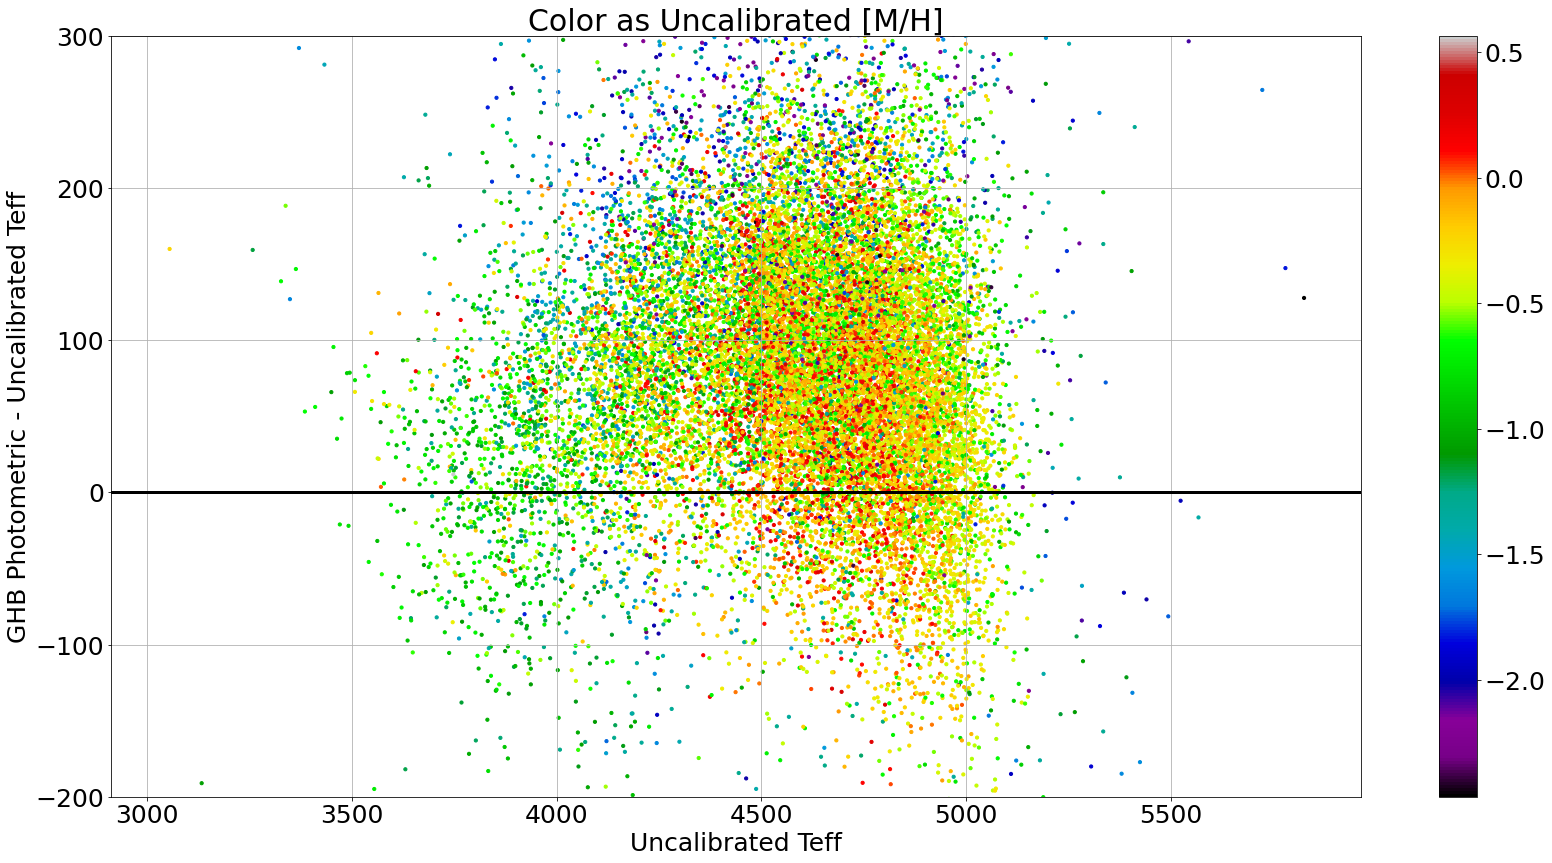

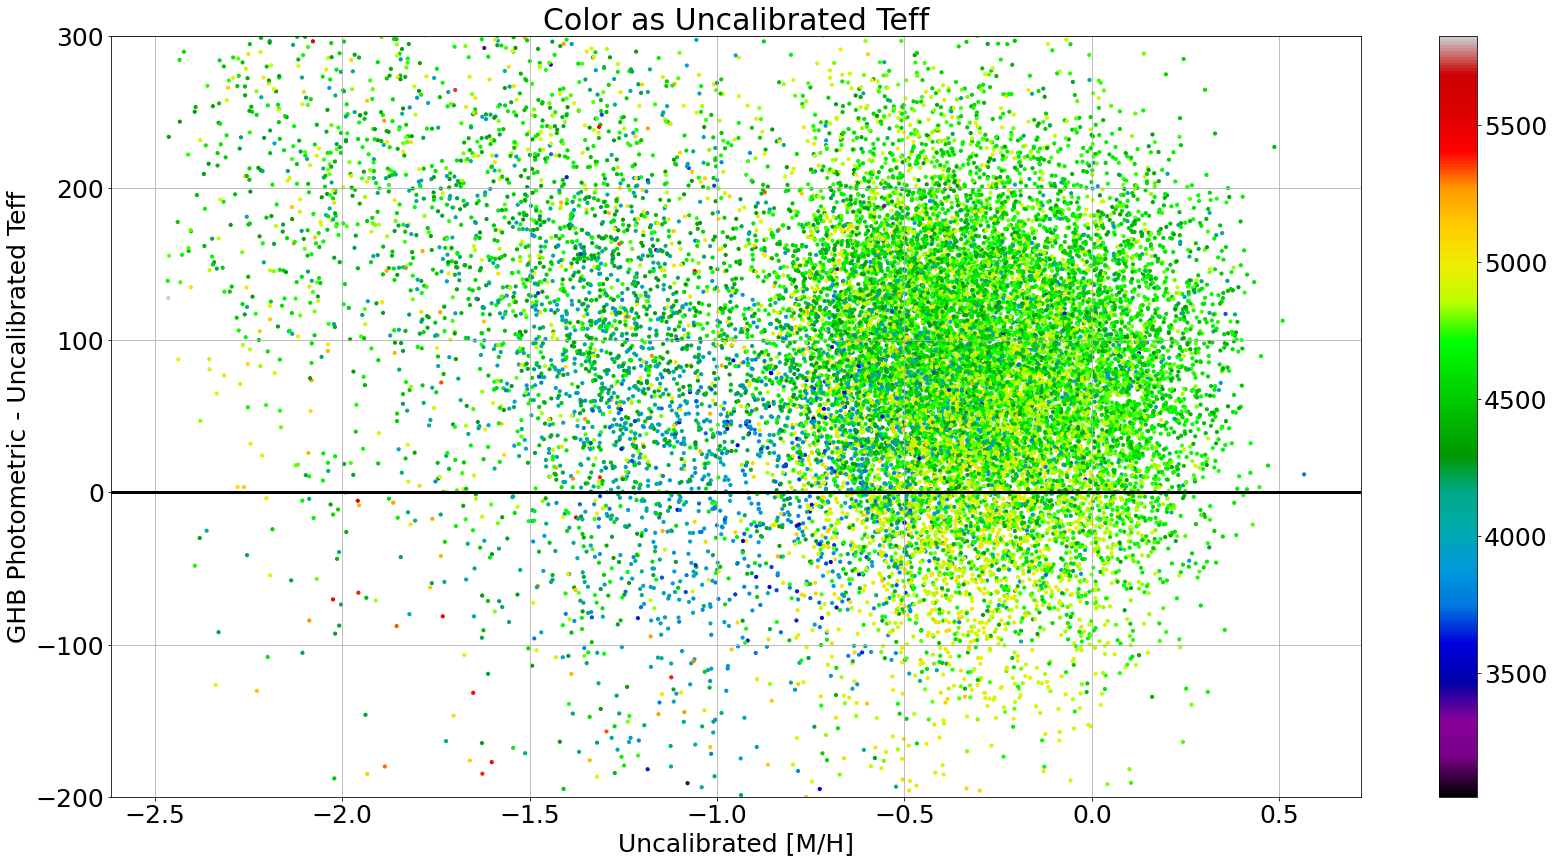

In [42]:
plt.figure(figsize=[28,14])
plt.scatter(rgb['fparam'][:,0],ghbteffs-rgb['fparam'][:,0],c=rgb['fparam'][:,3],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Teff')
plt.ylabel(r'GHB Photometric - Uncalibrated Teff')
plt.show()

###
plt.figure(figsize=[28,14])
plt.scatter(rgb['fparam'][:,3],ghbteffs-rgb['fparam'][:,0],c=rgb['fparam'][:,0],cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
# plt.ylim(-600,600)
plt.ylim(-200,300)
plt.grid()
plt.title(r'Color as Uncalibrated Teff')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'GHB Photometric - Uncalibra ted Teff')
plt.show()

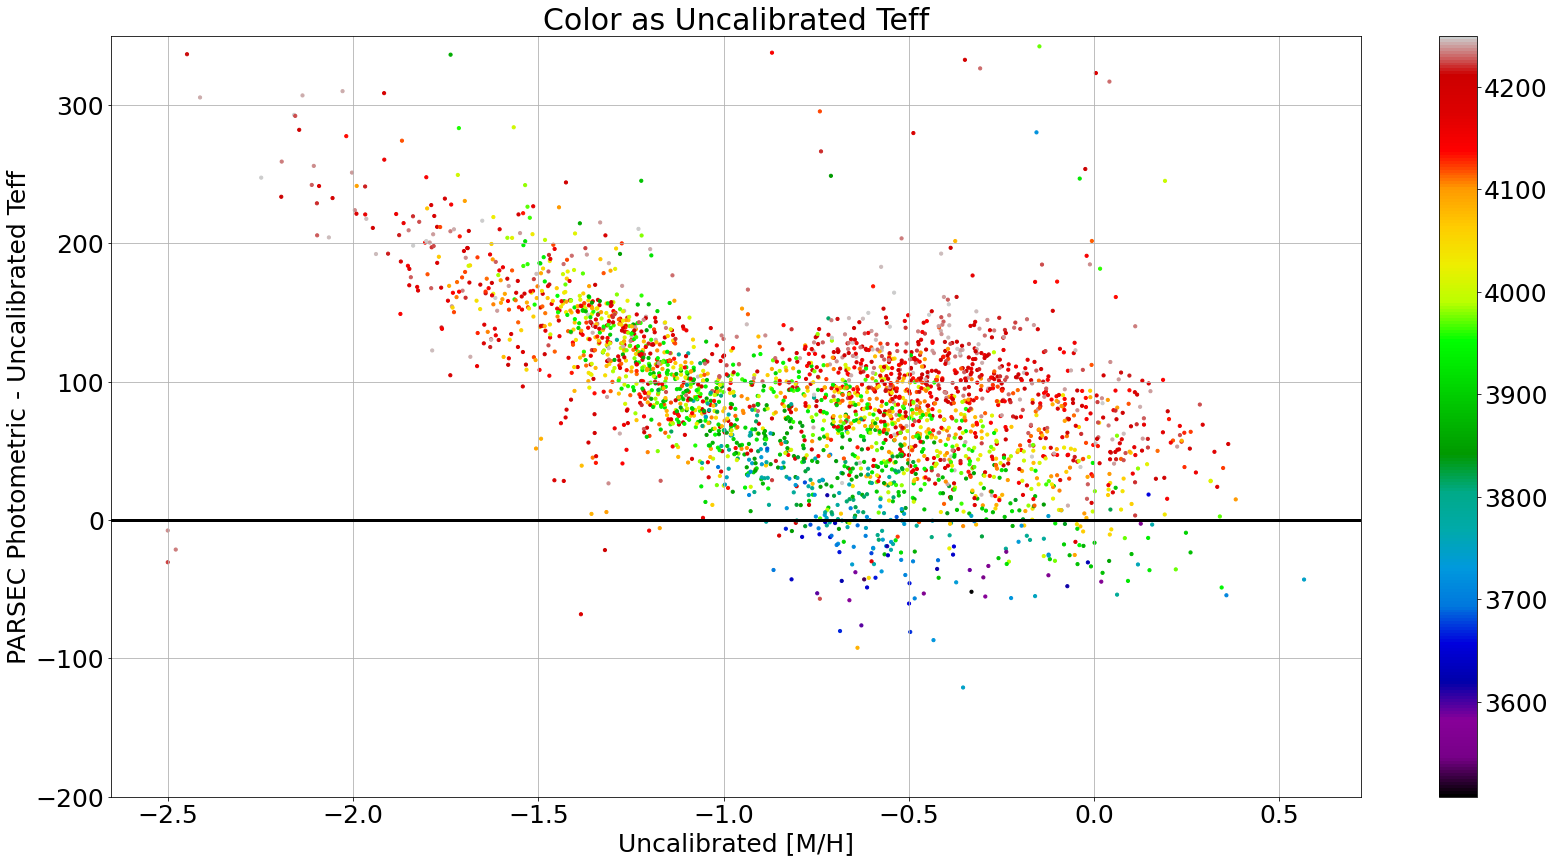

In [43]:
teffcut = np.where(rgb['fparam'][:,0]<4250)
###
plt.figure(figsize=[28,14])
plt.scatter(rgb['fparam'][:,3][teffcut],(photteffs-rgb['fparam'][:,0])[teffcut],c=rgb['fparam'][:,0][teffcut],
            cmap='nipy_spectral',s=10)
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-200,350)
plt.grid()
plt.title(r'Color as Uncalibrated Teff')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'PARSEC Photometric - Uncalibrated Teff')
plt.show()